<a href="https://colab.research.google.com/github/hmehryar/Hm.JetscapeMl/blob/309-implementingtraining-pointnet-for-alpha_s-with-various-epochs-and-folds-and-finding-the-best-learning-rate/jet_ml_pointnet_alpha_s/jet_ml_pointnet_alpha_s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install --upgrade tensorflow
import tensorflow as tf

In [2]:
# uncomment this cell when you are on COLAB
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))
# # from google.colab import drive
# # drive.mount('/content/drive')

In [3]:
import sys
sys.path.insert(1,'/wsu/home/gy/gy40/gy4065/hm.jetscapeml.source')
sys.path.insert(1,'/content/drive/My Drive/Projects/110_JetscapeMl/hm.jetscapeml.source')
sys.path.insert(1,'/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.source')
sys.path.insert(1,'/g/My Drive/Projects/110_JetscapeMl/hm.jetscapeml.source')
sys.path.insert(1,'G:\\My Drive\\Projects\\110_JetscapeMl\\hm.jetscapeml.source')

In [4]:
from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import set_directory_paths
dataset_directory_path, simulation_directory_path = set_directory_paths()


########################################################################
Checking the running platforms and setting the directory path

Python version: 3.11.5
OS: Windows
OS version: 10
running on Colab: False
Dataset Directory Path: D:\Projects\110_JetscapeMl\hm.jetscapeml.data\
Simulation Results Path: D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\
########################################################################



In [5]:
from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import get_labels_str
label_str_dict=get_labels_str()

Aggregatring all parameters values
label_items:
 {'eloss_items': ['MMAT', 'MLBT'], 'alpha_s_items': [0.2, 0.3, 0.4], 'q0_items': [1.5, 2.0, 2.5]}
Building required params for the loading the dataset file
labels_str:
 {'eloss_items_str': 'MMAT_MLBT', 'alpha_s_items_str': '0.2_0.3_0.4', 'q0_items_str': '1.5_2.0_2.5'}


In [6]:
with tf.device("CPU"):
    from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import get_dataset
    dataset_size=1000
    dataset_x, dataset_y=get_dataset(dataset_size,label_str_dict, dataset_directory_path,working_column=0,scale_x=True)

Loading the whole dataset
dataset.x: <class 'numpy.ndarray'> 1024000 (1000, 32, 32)
dataset.y: <class 'numpy.ndarray'> 3000 (1000, 3)
Scaling the datset_x each image between 0 and 1
Extract the working column#0 for classification
dataset.x: <class 'numpy.ndarray'> 1024000 (1000, 32, 32)
dataset.y: <class 'numpy.ndarray'> 1000 (1000,)
dataset.y(working_column) sample ['MLBT' 'MLBT' 'MLBT' 'MMAT' 'MMAT' 'MMAT' 'MMAT' 'MMAT' 'MLBT' 'MLBT']


In [7]:
with tf.device("CPU"):
    from jet_ml_models.pointnet import preprocess_dataset
    (x_train,  y_train,x_test,  y_test)=preprocess_dataset(dataset_x, dataset_y,is_one_hot_encoded=True)
    print("deleting original dataset")
    del dataset_x,dataset_y

Pre-processing
dataset_x_points shape: (1000, 1024, 3)
deleting the original dataset after splitting ...
train_points: <class 'numpy.ndarray'> 2457600 (800, 1024, 3)
train_y: <class 'numpy.ndarray'> 800 (800,)
x_test_points: <class 'numpy.ndarray'> 614400 (200, 1024, 3)
y_test: <class 'numpy.ndarray'> 200 (200,)
y_test[:10]:
 ['MLBT' 'MMAT' 'MMAT' 'MLBT' 'MLBT' 'MLBT' 'MMAT' 'MLBT' 'MLBT' 'MLBT']
Preprocess y_train and y_test
One-hot encode the categorical variable
y_test_categorical:
 [['MLBT']
 ['MMAT']
 ['MMAT']
 ['MLBT']
 ['MLBT']
 ['MLBT']
 ['MMAT']
 ['MLBT']
 ['MLBT']
 ['MLBT']]
y_test_categorical_encoded:
 [[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
deleting original dataset


In [8]:
with tf.device("CPU"):
    from jet_ml_models.pointnet import create_tf_dataset
    print("converting to tensor data")
    # Create TensorFlow Dataset for training data and test data
    dataset = create_tf_dataset(x_train, y_train)
    test_dataset = create_tf_dataset(x_test, y_test)
    len_x_train=len(x_train)
    len_x_test=len(x_test)
    print("deleting preprocessed dataset")
    del x_train,y_train,x_test,y_test

converting to tensor data
deleting preprocessed dataset


In [9]:
from jet_ml_models.pointnet import prepare_datasets
from jet_ml_models.pointnet import augment

with tf.device("CPU"):
    # Prepare datasets for training
    print("going to prepare dataset")
    train_dataset, validation_dataset,test_dataset = prepare_datasets(dataset, test_dataset, len_x_train, len_x_test, augment,train_size=1)
    print("deleting initial tensor dataset")
    del dataset

going to prepare dataset
deleting initial tensor dataset


In [10]:
with tf.device("CPU"):
    print(len(test_dataset))
    print(len(validation_dataset))

7
7


In [11]:
from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import generate_simulation_path
monitor = 'val_accuracy'  # 'val_accuracy' or 'val_loss'

classifying_parameter="eloss"
n_epochs = 100
fold = 1

current_simulation_path = generate_simulation_path(simulation_directory_path, classifying_parameter,label_str_dict, dataset_size, n_epochs, fold)
print("current_simulation_path:",current_simulation_path)

# Use ModelCheckpoint callback to save the best model
best_model_file_path = f'{current_simulation_path}_best_model.keras'
print("best_model_file_path:",best_model_file_path)

simulation_directory_path: D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\
simulation_path: D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_pointnet_classification_eloss_MMAT_MLBT
current_simulation_path: D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_pointnet_classification_eloss_MMAT_MLBT_size_1000_epochs_100_fold_1
best_model_file_path: D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_pointnet_classification_eloss_MMAT_MLBT_size_1000_epochs_100_fold_1_best_model.keras


In [12]:
from jet_ml_models.pointnet import build_pointnet_classifier_model

NUM_POINTS = 1024
#because alpha_s can get 3 values
NUM_CLASSES = 2
# activation="softmax"
activation="sigmoid"

pointnet=build_pointnet_classifier_model(NUM_POINTS=NUM_POINTS,NUM_CLASSES=NUM_CLASSES, activation=activation)


In [13]:
from jet_ml_models.pointnet import compile_pointnet_classifier_model_with_hyperparam
from jet_ml_models.pointnet import print_model_summary
learning_rate=0.001
# loss='sparse_categorical_crossentropy'
# loss='categorical_crossentropy',
loss="binary_crossentropy",
# metrics='sparse_categorical_accuracy'
metrics=['accuracy'],

pointnet=compile_pointnet_classifier_model_with_hyperparam(pointnet,learning_rate=learning_rate, loss=loss,metrics=metrics)
print_model_summary(pointnet)

Model: "pointnet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1024, 32)  │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024, 32)  │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1024, 32)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1024, 64)  │      2,112 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 64)  │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1024, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 1024, 512) │     33,280 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 512) │      2,048 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 1024, 512) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ activation_2[0][… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    131,328 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 9)         │      1,161 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 3, 3)      │          0 │ dense_2[0][0]   

 Total params: 747,947 (2.85 MB)

 Trainable params: 741,867 (2.83 MB)

 Non-trainable params: 6,080 (23.75 KB)

Optimizer:  <keras.src.optimizers.adam.Adam object at 0x000002432913C950>
Loss function:  binary_crossentropy
Metrics:  ['loss', 'compile_metrics']


In [14]:
# %%timeit -n1 -r1
from jet_ml_models.pointnet import train_model_with_callbacks
# monitor='val_sparse_categorical_accuracy'
monitor='val_accuracy'
with tf.device('/GPU:0'):
  model, history, train_time=train_model_with_callbacks(pointnet, train_dataset=train_dataset, validation_dataset=validation_dataset,monitor=monitor, best_model_file_path=best_model_file_path, n_epochs=n_epochs)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5153 - loss: 51.4922
Epoch 1: val_accuracy improved from -inf to 0.51500, saving model to D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_pointnet_classification_eloss_MMAT_MLBT_size_1000_epochs_100_fold_1_best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.5151 - loss: 51.1433 - val_accuracy: 0.5150 - val_loss: 34.1431
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5034 - loss: 34.9072
Epoch 2: val_accuracy did not improve from 0.51500
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5022 - loss: 34.9081 - val_accuracy: 0.5050 - val_loss: 33.8887
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5200 - loss: 34.9494
Epoch 3: val_accuracy improved from 0.51500 to 0.55000, saving model to D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_pointnet_classification_eloss_MMAT_MLBT_size_1000_epochs_100_fold_1_best_model.keras
25/25 ━

In [15]:
print(train_time)
print(model)
print(history.history)

29.58397560119629
<Functional name=pointnet, built=True>
{'accuracy': [0.5112500190734863, 0.4712499976158142, 0.5074999928474426, 0.5462499856948853, 0.5387499928474426, 0.543749988079071, 0.5087500214576721, 0.5600000023841858, 0.5625, 0.543749988079071, 0.5137500166893005, 0.5699999928474426, 0.5137500166893005, 0.48750001192092896, 0.5249999761581421, 0.5525000095367432, 0.5237500071525574, 0.5425000190734863, 0.5712500214576721, 0.5575000047683716, 0.5674999952316284, 0.5475000143051147, 0.5874999761581421, 0.5712500214576721, 0.5537499785423279, 0.5699999928474426, 0.5387499928474426, 0.5662500262260437, 0.5712500214576721, 0.581250011920929, 0.5774999856948853, 0.5737500190734863, 0.5637500286102295, 0.5799999833106995, 0.574999988079071, 0.5987499952316284, 0.5600000023841858, 0.5337499976158142, 0.5600000023841858, 0.5887500047683716, 0.5212500095367432, 0.5687500238418579, 0.5600000023841858, 0.5425000190734863, 0.5487499833106995, 0.4749999940395355, 0.5224999785423279, 0.55

In [16]:
from jet_ml_models.pointnet import save_training_history
training_history_file_path_json,training_history_file_path_csv,training_history_file_path_csv = \
  save_training_history(history,current_simulation_path)

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_pointnet_classification_eloss_MMAT_MLBT_size_1000_epochs_100_fold_1_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_pointnet_classification_eloss_MMAT_MLBT_size_1000_epochs_100_fold_1_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_pointnet_classification_eloss_MMAT_MLBT_size_1000_epochs_100_fold_1_training_history.npy


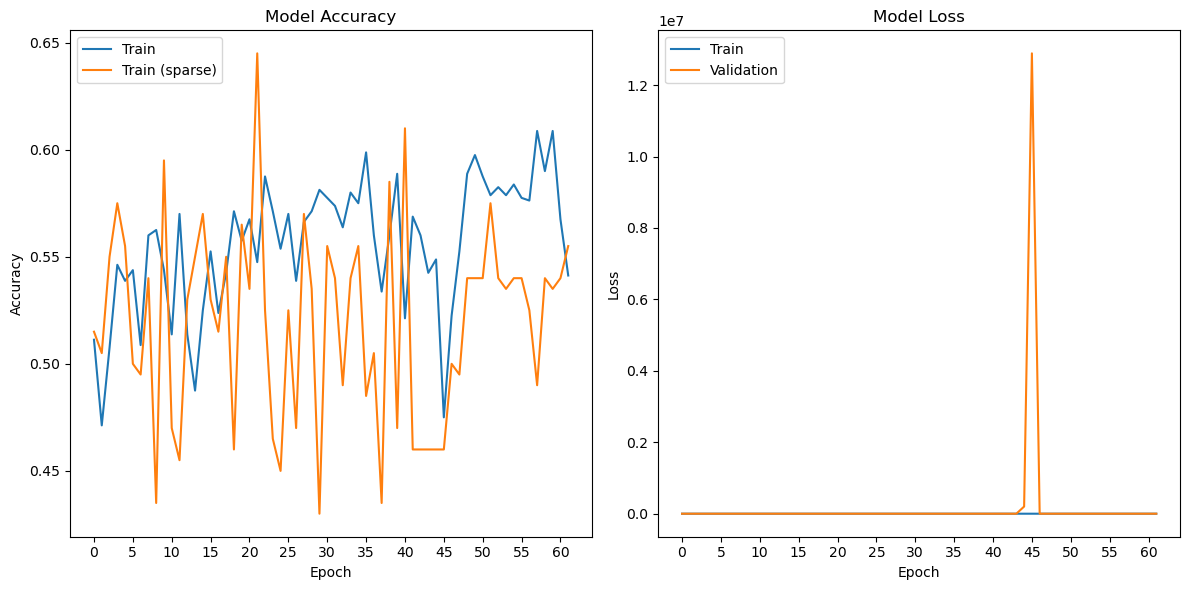

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_pointnet_classification_eloss_MMAT_MLBT_size_1000_epochs_100_fold_1_accuracy_loss.png


In [17]:
from jet_ml_models.pointnet import plot_training_history
plot_training_history_path=plot_training_history(history,current_simulation_path)
print(plot_training_history_path)

In [25]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
def evaluate_model(model, x_test=None, y_test=None, test_dataset=None):
    """
    Evaluate the performance of a trained model on test data.

    Parameters:
    - model: The trained deep neural model.
    - x_test: Test data features (optional if test_dataset is provided).
    - y_test: True labels (optional if test_dataset is provided).
    - test_dataset: TensorFlow Dataset containing test data (optional if x_test and y_test are provided).

    Returns:
    - accuracy: Accuracy of the model on the test data.
    - confusion_matrix: Confusion matrix for the predictions.
    """
    if test_dataset is None:
        if x_test is None or y_test is None:
            raise ValueError("Either provide test_dataset or provide x_test and y_test.")

        y_pred = model.predict(x_test)
        y_pred_class = np.argmax(y_pred, axis=1)

        y_true_class = np.argmax(y_test, axis=1)

    else:
        y_pred_probs = model.predict(test_dataset)
        y_pred_class = np.argmax(y_pred_probs, axis=1)
        print(np.max(y_pred_class))
        
        print(test_dataset.y)
        y_true_class = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)
        y_true_class = np.argmax(y_test, axis=1)


    accuracy = accuracy_score(y_true_class, y_pred_class)
    print(f'Accuracy: {accuracy}')

    cm = confusion_matrix(y_true_class, y_pred_class)
    print(f'Confusion Matrix: {cm}')

    return accuracy, cm

In [33]:
 y_pred_probs = model.predict(test_dataset)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


In [34]:
print(y_pred_probs)

[[0.5183368  0.48451197]
 [0.56539744 0.41062492]
 [0.43005952 0.58067536]
 [0.4359925  0.5729748 ]
 [0.44621265 0.5629266 ]
 [0.59489775 0.40542427]
 [0.62455165 0.34847194]
 [0.6077119  0.37885863]
 [0.44866332 0.5572919 ]
 [0.44241205 0.565863  ]
 [0.43600655 0.57265306]
 [0.44832042 0.55383456]
 [0.43732753 0.5705975 ]
 [0.6162633  0.3360101 ]
 [0.43348286 0.5766351 ]
 [0.6183407  0.33661285]
 [0.6404519  0.33823478]
 [0.5845449  0.41303816]
 [0.5560244  0.43735188]
 [0.43939784 0.5702691 ]
 [0.61005175 0.3811342 ]
 [0.57088864 0.42116526]
 [0.45329157 0.55351347]
 [0.42844462 0.5838044 ]
 [0.4406952  0.5669472 ]
 [0.51804495 0.48068917]
 [0.54187554 0.45851332]
 [0.5931984  0.35363886]
 [0.4354666  0.57495844]
 [0.6402185  0.33864248]
 [0.5624567  0.43518865]
 [0.60777164 0.3753233 ]
 [0.6241779  0.3622059 ]
 [0.43333212 0.5766462 ]
 [0.44563782 0.56149423]
 [0.492162   0.50914294]
 [0.44754234 0.5605413 ]
 [0.56958205 0.43155074]
 [0.58341634 0.38876936]
 [0.518329   0.48608547]


In [36]:
y_pred_class = np.argmax(y_pred_probs, axis=1)
print(y_pred_class)

[0 0 1 1 1 0 0 0 1 1 1 1 1 0 1 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 1 1 1
 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1
 0 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0 0 0 1 0 1 1 1 1 0 0 1 1 0 0 0 1 0
 0 0 1 1 1 0 0 0 1 1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 0 0 1 0 0 0 1
 0 1 0 1 0 1 0 1 1 1 1 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 0
 1 1 0 1 1 1 0 0 0 1 1 1 1 1 0]


In [53]:
test_y_class=[y.numpy() for _, y in test_dataset]
print(test_y_class)
conc=np.concatenate(test_y_class,axis=0)
print(conc)
# y_true_class = np.argmax(conc, axis=1)
y in test_dataset


[array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]]), array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0.,

In [26]:
accuracy, confusion_matrix = evaluate_model(model,test_dataset=test_dataset)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step
1
<_BatchDataset element_spec=(TensorSpec(shape=(None, 1024, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 2), dtype=tf.float64, name=None))>


ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

In [18]:
from jet_ml_models.pointnet import evaluate_model
accuracy, confusion_matrix = evaluate_model(model,test_dataset=test_dataset)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

In [ ]:
from jet_ml_models.pointnet import save_kfold_results
results_kfold = []
results_kfold.append({
                  'Dataset Size': dataset_size,
                  'Classifier': model.name,
                  'Fold Number': fold,
                  'Accuracy': accuracy,
                  'Confusion Matrix': confusion_matrix,
                  'Train Time': train_time,
                  'Loss/Accuracy Plot Path': plot_training_history_path,
                  'Best Model Path': best_model_file_path
              })
save_kfold_results(results_kfold, current_simulation_path)